# IMDB data set part III: A new dimension in error

After spending way too much time getting data and cleaning it (see part I and part II), now, I can finaly look at the distribution of each variable and the relation between them. In this blog post, I'll finish the exploration of the IMDB data set and make some hypotheses on the best model to use to predict the profitability of a movie. 

In [124]:
library(dplyr)
library(data.table)
library(bit64)
library(plotly)
library(corrplot)
options(scipen=999)

In [125]:
movies <- fread("movie_budget_us_2016.csv",stringsAsFactors = F)
head(movies)

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,genres_Sci-Fi,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016
Color,Joon-ho Bong,363,110,584,74,Kang-ho Song,629,2201412,Comedy|Drama|Horror|Sci-Fi,...,1,0,0,0,0,0,KOR,12793905,2620914.8,15231922
Color,Chan-wook Park,202,112,0,38,Yeong-ae Lee,717,211667,Crime|Drama,...,0,0,0,0,0,0,KOR,4101095,260131.9,5040113
Color,Lajos Koltai,73,134,45,0,PÃ©ter Fancsikai,9,195888,Drama|Romance|War,...,0,0,0,0,1,0,HUN,12526148,240740.0,15394231
Color,Hayao Miyazaki,174,134,6000,745,Jada Pinkett Smith,893,2298191,Adventure|Animation|Fantasy,...,0,0,0,0,0,0,JPN,19836208,3436293.2,29659426
Color,Katsuhiro Ã”tomo,105,103,78,101,Robin Atkin Downes,488,410388,Action|Adventure|Animation|Family|Sci-Fi|Thriller,...,1,0,0,1,0,0,JPN,19664196,521465.0,24986575
Color,Katsuhiro Ã”tomo,150,124,78,4,Takeshi Kusao,6,439162,Action|Animation|Sci-Fi,...,1,0,0,0,0,0,JPN,8583579,891286.1,17420507


In [126]:
str(movies)

Classes 'data.table' and 'data.frame':	4817 obs. of  58 variables:
 $ color                    : chr  "Color" "Color" "Color" "Color" ...
 $ director_name            : chr  "Joon-ho Bong" "Chan-wook Park" "Lajos Koltai" "Hayao Miyazaki" ...
 $ num_critic_for_reviews   : int  363 202 73 174 105 150 107 20 35 41 ...
 $ duration                 : int  110 112 134 134 103 124 99 193 115 90 ...
 $ director_facebook_likes  : int  584 0 45 6000 78 78 2 160 98 116 ...
 $ actor_3_facebook_likes   : int  74 38 0 745 101 4 3 860 4 303 ...
 $ actor_2_name             : chr  "Kang-ho Song" "Yeong-ae Lee" "PÃ©ter Fancsikai" "Jada Pinkett Smith" ...
 $ actor_1_facebook_likes   : int  629 717 9 893 488 6 43 8000 341 594 ...
 $ gross                    : chr  "2201412" "211667" "195888" "2298191" ...
 $ genres                   : chr  "Comedy|Drama|Horror|Sci-Fi" "Crime|Drama" "Drama|Romance|War" "Adventure|Animation|Fantasy" ...
 $ actor_1_name             : chr  "Doona Bae" "Min-sik Choi" "Marcell Na

I have to change the encoding of certain variable to their correct format.

In [127]:
movies$color<-as.factor(movies$color) 
movies$director_name<-as.factor(movies$director_name)
movies$actor_2_name<-as.factor(movies$actor_2_name)

movies$gross<-as.integer(movies$gross)

movies$actor_1_name<-as.factor(movies$actor_1_name)
movies$actor_3_name<-as.factor(movies$actor_3_name)
movies$language<-as.factor(movies$language)
movies$country<-as.factor(movies$country)
movies$content_rating<-as.factor(movies$content_rating)
movies$aspect_ratio<-as.factor(movies$aspect_ratio)

movies$movie_facebook_likes<-as.integer(movies$movie_facebook_likes)
movies$genres_Action<-as.integer(movies$genres_Action)

Let's look at the distribution of each variable.

In [128]:
summary(movies)

             color               director_name  num_critic_for_reviews
 Black and White: 201   Steven Spielberg:  26   Min.   :  1.0         
 Color          :4616   Woody Allen     :  22   1st Qu.: 52.0         
                        Clint Eastwood  :  20   Median :111.0         
                        Martin Scorsese :  20   Mean   :140.3         
                        Ridley Scott    :  16   3rd Qu.:194.0         
                        (Other)         :4711   Max.   :813.0         
                        NA's            :   2   NA's   :44            
    duration     director_facebook_likes actor_3_facebook_likes
 Min.   :  7.0   Min.   :    0.0         Min.   :    0.0       
 1st Qu.: 94.0   1st Qu.:    7.0         1st Qu.:  131.0       
 Median :104.0   Median :   48.0         Median :  367.0       
 Mean   :108.1   Mean   :  690.9         Mean   :  636.9       
 3rd Qu.:118.0   3rd Qu.:  189.5         3rd Qu.:  636.0       
 Max.   :334.0   Max.   :23000.0         Max.   

# Movie specific statistics

In this section, I will look at the variables describing the movies themselves. Specifictly, I'll look at the colorisation of the movies, their duration, their title, their gross revenu and their budget. 

In [129]:
summary(movies$color)

Black and White           Color 
            201            4616

In [130]:
hist_color <- plot_ly(movies,x=~color,color=~color,type="histogram") %>%
layout(title = 'Distribution of movie\'s color in the IMDB data set',
         xaxis = list(title = 'Color of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency',range = c(0,5000)))
embed_notebook(hist_color)

Warning message in RColorBrewer::brewer.pal(N, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

I'm interested to see how the colorisation of movie chande over the years for the movie in the data set.

In [131]:
temp<-movies[,c("title_year","color"),with=FALSE]

In [132]:
decade<-function(x){
    d<-as.double(x)
    
    return ((floor(d/10))*10)
}

In [133]:
temp$decades<-decade(temp$title_year)
head(temp$decades)

[1] 2000 2000 2000 1990 2000 1980

In [134]:
str(temp)

Classes 'data.table' and 'data.frame':	4817 obs. of  3 variables:
 $ title_year: chr  "2006" "2005" "2005" "1997" ...
 $ color     : Factor w/ 2 levels "Black and White",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ decades   : num  2000 2000 2000 1990 2000 1980 1990 2000 1990 2010 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [135]:
hist_color_decade <- temp %>%
  dplyr::count(color,decades) %>%
  plot_ly(x =~decades, y = ~n,color=~color) %>% 
  add_bars()%>%
layout(title = 'Distribution of movie\'s color in the IMDB data set by decade',
         xaxis = list(title = 'Color of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_color_decade)

Warning message:
"Ignoring 1 observations"Warning message in RColorBrewer::brewer.pal(N, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

In [136]:
hist_color_year <- temp %>%
  dplyr::count(color,title_year) %>%
  plot_ly(x =~title_year, y = ~n,color=~color) %>% 
add_bars()%>%
layout(title = 'Distribution of movie\'s color in the IMDB data set by year',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_color_year) 

No trace type specified:
  Based on info supplied, a 'bar' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#bar
Warning message:
"Ignoring 1 observations"Warning message in RColorBrewer::brewer.pal(N, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

In [137]:
freq_color_year<-temp %>%
group_by(title_year,color) %>%
tally%>%
mutate(freq=n/sum(n))

In [138]:
levels(freq_color_year$color)[levels(freq_color_year$color)=="Black and White"]<-"BW"
head(freq_color_year)

title_year,color,n,freq
1916,BW,1,1
1920,BW,1,1
1925,BW,1,1
1927,BW,1,1
1929,BW,2,1
1930,BW,1,1


In [139]:
freq_color_year$title_year<-as.integer(freq_color_year$title_year)

In [140]:
library(tidyr)

In [141]:
freq_color_spread<-spread(freq_color_year,color,value=freq)
head(freq_color_spread,n=5)

title_year,n,BW,Color
1916,1,1,NA
1920,1,1,NA
1925,1,1,NA
1927,1,1,NA
1929,2,1,NA


In [142]:
plot_color_freq<-plot_ly(freq_color_spread, x = ~title_year) %>%
add_trace(y=~BW,name = 'trace 0', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~Color,name = 'trace 1', type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Trend line of the proportion ofmovie\'s color in the IMDB data set over the year',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Relative frequency'))
embed_notebook(plot_color_freq)

We can see that the number of movies in black and white stay stable over time, but the overall number of movie grow soo much that their relative frequency is almost zero near the 90's.

Now I take a look at the "duration" variable.

In [143]:
summary(movies$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    7.0    94.0   104.0   108.1   118.0   334.0      13 

In [144]:
hist_duration <- plot_ly(x=~movies$duration,type="histogram")%>%
layout(title = 'Distribution of the length of the movie in the IMDB data set',
         xaxis = list(title = 'Duration of movie', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_duration)

Warning message:
"Ignoring 13 observations"

There seem's to be some outlier in the data. By drawing a box plot, I can easily find the value that are suspicus.

In [145]:
box_duration <- plot_ly(x=~movies$duration,type="box")%>%
layout(title = 'Distribution of the length of the movie in the IMDB data set',
         xaxis = list(title = 'Duration of movie', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(box_duration)

Warning message:
"Ignoring 13 observations"

In [146]:
movies[duration<59,movie_imdb_link]

[1] "http://www.imdb.com/title/tt0920458/?ref_=fn_tt_tt_1"
 [2] "http://www.imdb.com/title/tt0245280/?ref_=fn_tt_tt_1"
 [3] "http://www.imdb.com/title/tt4061848/?ref_=fn_tt_tt_1"
 [4] "http://www.imdb.com/title/tt0996382/?ref_=fn_tt_tt_1"
 [5] "http://www.imdb.com/title/tt1529567/?ref_=fn_tt_tt_1"
 [6] "http://www.imdb.com/title/tt0092991/?ref_=fn_tt_tt_1"
 [7] "http://www.imdb.com/title/tt0473107/?ref_=fn_tt_tt_1"
 [8] "http://www.imdb.com/title/tt0854678/?ref_=fn_tt_tt_1"
 [9] "http://www.imdb.com/title/tt4273494/?ref_=fn_tt_tt_1"
[10] "http://www.imdb.com/title/tt0059026/?ref_=fn_tt_tt_1"
[11] "http://www.imdb.com/title/tt0478988/?ref_=fn_tt_tt_1"
[12] "http://www.imdb.com/title/tt0283465/?ref_=fn_tt_tt_1"
[13] "http://www.imdb.com/title/tt1128219/?ref_=fn_tt_tt_1"
[14] "http://www.imdb.com/title/tt1869849/?ref_=fn_tt_tt_1"
[15] "http://www.imdb.com/title/tt0092337/?ref_=fn_tt_tt_1"
[16] "http://www.imdb.com/title/tt2164708/?ref_=fn_tt_tt_1"
[17] "http://www.imdb.com/title/tt1003002/?ref_=fn_tt_tt_1"

Looking at the IMDB page of those suspicious data, I found out that most of them are either short film, small documentary or mini serie who had theater release. In those case, the episode running time is often written with the running time of the theatrical cut which cause the difference in time. Since the number of problematic observation is really small, I won't change the data set. 

Now, I look at movie who are suspiciusly long. The box-plot tell us that movie with a length of more than 154 is suspicious, but a lot of movie these day last more than 200 minutes. In consequence, I'll look at movie who are longer than 200 minutes to see for outlier.

In [147]:
movies[duration>200&duration<300,movie_imdb_link]

[1] "http://www.imdb.com/title/tt0360717/?ref_=fn_tt_tt_1"
 [2] "http://www.imdb.com/title/tt0346491/?ref_=fn_tt_tt_1"
 [3] "http://www.imdb.com/title/tt0409459/?ref_=fn_tt_tt_1"
 [4] "http://www.imdb.com/title/tt0993846/?ref_=fn_tt_tt_1"
 [5] "http://www.imdb.com/title/tt0217505/?ref_=fn_tt_tt_1"
 [6] "http://www.imdb.com/title/tt0111756/?ref_=fn_tt_tt_1"
 [7] "http://www.imdb.com/title/tt0149624/?ref_=fn_tt_tt_1"
 [8] "http://www.imdb.com/title/tt0279111/?ref_=fn_tt_tt_1"
 [9] "http://www.imdb.com/title/tt0120863/?ref_=fn_tt_tt_1"
[10] "http://www.imdb.com/title/tt0113987/?ref_=fn_tt_tt_1"
[11] "http://www.imdb.com/title/tt0102138/?ref_=fn_tt_tt_1"
[12] "http://www.imdb.com/title/tt0104797/?ref_=fn_tt_tt_1"
[13] "http://www.imdb.com/title/tt0078788/?ref_=fn_tt_tt_1"
[14] "http://www.imdb.com/title/tt0056937/?ref_=fn_tt_tt_1"
[15] "http://www.imdb.com/title/tt0087843/?ref_=fn_tt_tt_1"
[16] "http://www.imdb.com/title/tt0107007/?ref_=fn_tt_tt_1"
[17] "http://www.imdb.com/title/tt0837106/?ref_=fn_tt_tt_1"
[18] "http://www.imdb.com/title/tt0093389/?ref_=fn_tt_tt_1"
[19] "http://www.imdb.com/title/tt0083987/?ref_=fn_tt_tt_1"
[20] "http://www.imdb.com/title/tt0099348/?ref_=fn_tt_tt_1"
[21] "http://www.imdb.com/title/tt0059245/?ref_=fn_tt_tt_1"
[22] "http://www.imdb.com/title/tt0056172/?ref_=fn_tt_tt_1"
[23] "http://www.imdb.com/title/tt0082096/?ref_=fn_tt_tt_1"
[24] "http://www.imdb.com/title/tt0071562/?ref_=fn_tt_tt_1"
[25] "http://www.imdb.com/title/tt0031381/?ref_=fn_tt_tt_1"
[26] "http://www.imdb.com/title/tt0047478/?ref_=fn_tt_tt_1"
[27] "http://www.imdb.com/title/tt0066580/?ref_=fn_tt_tt_1"

In [148]:
movies[duration>300,movie_imdb_link]

[1] "http://www.imdb.com/title/tt0080855/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt0106469/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt1321865/?ref_=fn_tt_tt_1"

I looked at the IMDB page of the majority of those movie and all the duration seem correct. The only thing that could add some variability in the model is the fact that some movie have multiple cut and it is impossible to know if the value of the duration in the data set is the one of the cut that made it in the majority of the theater.

After that, I looked at the variable "movie_title". First of all, I'm interested to know the distribution of the number of letter in the title of the movies.

In [149]:
title_length<-data.frame("Title"=movies$movie_title,"Length"=nchar(movies$movie_title),"Gross"=movies$gross)
head(title_length)

Title,Length,Gross
thehost,7,2201412
ladyvengeance,13,211667
fateless,8,195888
princessmononoke,16,2298191
steamboy,8,410388
akira,5,439162


In [150]:
hist_length <- title_length %>%
  dplyr::count(Length) %>%
  plot_ly(x =~Length, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of movie\'s title length in the IMDB data set',
         xaxis = list(title = 'Length of the movies title', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_length)

Here again there seem's to be some outlier in the data and to make sure that isn't the case, I looked at the longest movie title.

In [151]:
head(title_length[order(-title_length$Length),],n=10)

,Title,Length,Gross
3845,30nightsofparanormalactivitywiththedevilinsidethegirlwiththedragontattoo,72,0
2310,boratculturallearningsofamericaformakebenefitgloriousnationofkazakhstan,71,128505958
4132,the41yearoldvirginwhoknockedupsarahmarshallandfeltsuperbadaboutit,65,NA
3967,everythingyoualwayswantedtoknowaboutsexbutwereafraidtoask,57,NA
4040,drstrangeloveorhowilearnedtostopworryingandlovethebomb,54,NA
4226,onceinalifetimetheextraordinarystoryofthenewyorkcosmos,54,144431
78,thechroniclesofnarniathelionthewitchandthewardrobe,50,291709845
1645,theassassinationofjessejamesbythecowardrobertford,49,3904982
4371,deceptivepracticethemysteriesandmentorsofrickyjay,49,151389
1709,alexanderandtheterriblehorriblenogoodverybadday,47,66950483


I learn two things by searching those movie: first they are all legit movie, there was no error in the data gathering; second some porno produceur like to concatenate name of popular movie and use that as the name for their movie, probably to maximaze their google ranking. Well I knew I'll learn something by analysing that data set! 

I'm interested to know if the length of a movie influence his performance at the box-office.

In [152]:
temp<-title_length[!is.na(title_length$Gross),]
fit <- lm(Gross ~ Length, data = temp)
scat_title_gross<-plot_ly(temp,x=~Length,y=~Gross)%>% 
add_markers(color=~Gross, alpha = 0.4)%>% 
add_trace(data=temp,x = ~Length, y = ~fitted(fit), mode = "lines")

embed_notebook(scat_title_gross)

No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter


We can see from this plot that the length of a movie title has little to do with the box-office revenu of a movie. Sad.

Next: I analyse at the "facenumber_in_poster" variable. This variable is a attempt to quantify the phenomenon of "the giant floating head" seen in a lot of movie poster like this one:<img src="image/ghost_rider.jpg">

or this one:<img src="image/scream_2.jpg">

or those one:<img src="image/Movie-Posters-That-Look-Similar-13.jpg" style="width:50%">

As you can see, it's an overuse poster style.

In [153]:
summary(movies$facenumber_in_poster)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   1.000   1.368   2.000  43.000      13 

In [154]:
scat_title_gross<-movies%>% 
  dplyr::count(facenumber_in_poster) %>%
  plot_ly(x =~facenumber_in_poster, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of face on the movie poster',
         xaxis = list(title = 'Number of faces', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(scat_title_gross)

Warning message:
"Ignoring 1 observations"

The maximal value taken by the variable "facenumber_in_poster" that count the number of head on the movie poster is 43, which is quite high. Since the number of head in each poster has been counted by a face recognicion algorithm, I suspect that this is an aberrant value. If that's not the case, investigating these data is worth my time just to find what kind of abobination of a poster can containt that many head.

In [155]:
faaaaaaaaaaace<-data.table(movie_title=movies$movie_title,facenumber=movies$facenumber)
faaaaaaaaaaace<-faaaaaaaaaaace[order(-movies$facenumber)]
head(faaaaaaaaaaace, n=10)

movie_title,facenumber
500daysofsummer,43
themaster,31
battleoftheyear,19
theexpendables3,15
newyearseve,15
cheaperbythedozen,15
asitisinheaven,15
boogienights,15
shouldvebeenromeo,15
abridgetoofar,14


Mother of god: the movies "500 Days of Summer" poster really has 43 faces on it! 
<img src="image/500_days_of_summer.jpg" style="width:50%">

I also looked at the poster of 10 movies who have the most head on their poster and the face recognition algorithm was on mark. As an exemple, here's the poster of "The master" movie: <img src="image/The_master.jpg" style="width:50%">

I conclude that there's no outlier in those data, just marketing executive that pushed the concept of the giant floating head too far.

After looking at the number of face in each movie poster, I analyse the genre of the movie.

In [156]:
col_genre<-c("genres_Action", "genres_Adventure", "genres_Animation", "genres_Biography", "genres_Comedy", "genres_Crime",
"genres_Documentary", "genres_Drama", "genres_Family", "genres_Fantasy", "genres_Film-Noir", "genres_Game-Show",
 "genres_History", "genres_Horror", "genres_Music", "genres_Musical", "genres_Mystery","genres_News","genres_Reality-TV",
"genres_Romance", "genres_Sci-Fi","genres_Short", "genres_Sport","genres_Thriller","genres_War","genres_Western", "gross")

genre_gross<-movies[,col_genre,with=FALSE]

In [157]:
count_genre_gross<-sapply(genre_gross, function(x)sum(as.numeric(x),na.rm=TRUE))
sum_genre_gross<-sapply(genre_gross, function(x)sum(as.numeric(x*genre_gross$gross),na.rm=TRUE))
stat_genre_gross<-data.frame(Count=count_genre_gross,Sum=sum_genre_gross)
str(stat_genre_gross)

Warning message in x * genre_gross$gross:
"NA produit par débordement d'entier par le haut"

'data.frame':	27 obs. of  2 variables:
 $ Count: num  1094 877 233 290 1813 ...
 $ Sum  : num  71844560555 75440686524 21483583536 9143454008 76749009842 ...


In [158]:
stat_genre_gross$Mean<-stat_genre_gross$Sum/stat_genre_gross$Count
stat_genre_gross$Name<-col_genre
head(stat_genre_gross)

,Count,Sum,Mean,Name
genres_Action,1094,71844560555,65671445,genres_Action
genres_Adventure,877,75440686524,86021307,genres_Adventure
genres_Animation,233,21483583536,92204221,genres_Animation
genres_Biography,290,9143454008,31529152,genres_Biography
genres_Comedy,1813,76749009842,42332603,genres_Comedy
genres_Crime,838,27723849524,33083353,genres_Crime


In [159]:
stat_genre_gross$Name<-substr(stat_genre_gross$Name,8,nchar(stat_genre_gross$Name))

In [160]:
hist_genre<-plot_ly(stat_genre_gross,x=~Name,y=~Mean)%>% 
    add_bars()%>%
    layout(title = 'Mean gross by genre',
             xaxis = list(title = ''),
             yaxis = list(title = 'Total gross'))
embed_notebook(hist_genre)

Warning message:
"Ignoring 2 observations"

The histogram suggest that the genre of movie influence significatively the gross revenu of a movie. Also that plot give me some insigth on why I can't find a good film-noir to watch on a rainy monday nigth: they make as much money than short movie. Sad.

After looking at the genre of a movie, I look at the distribution of the language use in the movie data set.

In [161]:
summary(movies$language,maxsum=10)

English    French   Spanish     Hindi  Mandarin    German  Japanese Cantonese 
     4488        72        40        28        24        19        16        11 
  (Other)      NA's 
      108        11

In [162]:
hist_lg<-movies%>% 
  dplyr::count(language) %>%
  plot_ly(x =~language, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Language used in the movies from the IMDB data set',
         xaxis = list(title = 'Language', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_lg)

Warning message:
"Ignoring 1 observations"

There's so many movies of english language in the data set, that this graph is not really usefull. Let's remove those movies from the set and draw the histogram of the non-english movies. 

In [163]:
temp<-
hist_lg_english_out<-movies[language!="English"]%>% 
  dplyr::count(language) %>%
  plot_ly(x =~language, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Non english language used in the movies from the IMDB data set',
         xaxis = list(title = 'Language', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_lg_english_out)

Soo the French, spanish and hindi are the most use language apart english in the data set.

Lett's look at the country of production of each movie.

In [164]:
summary(movies$country,maxsum=10)

USA        UK    France    Canada   Germany Australia     India     Spain 
     3637       420       153       121        94        51        34        33 
  (Other)      NA's 
      271         3

In [165]:
hist_country<-movies%>% 
  dplyr::count(country) %>%
  plot_ly(x =~country, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Country of origin of the movies from the IMDB data set',
         xaxis = list(title = 'Country'),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_country)

Warning message:
"Ignoring 1 observations"

In [166]:
hist_country<-movies[country!="USA"]%>% 
  dplyr::count(country) %>%
  plot_ly(x =~country, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Country of origin of the movies from the IMDB data set',
         xaxis = list(title = 'Country', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_country)

Now we look at the "content_rating" variable.

In [167]:
summary(movies$content_rating)

Approved         G        GP         M     NC-17 Not Rated    Passed        PG 
       54       112         6         5         7       115         9       686 
    PG-13         R     TV-14      TV-G     TV-MA     TV-PG   Unrated         X 
     1410      2069         3         4         1         3        59        12 
     NA's 
      262

In [168]:
hist_rating<-movies%>% 
  dplyr::count(content_rating) %>%
  plot_ly(x =~content_rating, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Content rating of the movies from the IMDB data set',
         xaxis = list(title = 'Content rating', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_rating)

Warning message:
"Ignoring 1 observations"

I'm not really familiar with some of the content rating, so I'll look at them more in detail, by looking at the movie with those rating.

In [169]:
movies[content_rating=="TV-14",movie_imdb_link]

[1] "http://www.imdb.com/title/tt2479478/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt1477109/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt2724064/?ref_=fn_tt_tt_1"

In [170]:
movies[content_rating=="TV-G",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0810900/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt0475293/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt2395247/?ref_=fn_tt_tt_1"
[4] "http://www.imdb.com/title/tt0059026/?ref_=fn_tt_tt_1"

In [171]:
movies[content_rating=="TV-MA",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0092337/?ref_=fn_tt_tt_1"

In [172]:
movies[content_rating=="TV-PG",movie_imdb_link]

[1] "http://www.imdb.com/title/tt2063015/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt1663628/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt1675312/?ref_=fn_tt_tt_1"

Those are made for tv movie who generally had a theatrical release. In consequence, these movies have a place in the data set.

In [173]:
movies[content_rating=="M",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0064757/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt0064115/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt0065112/?ref_=fn_tt_tt_1"
[4] "http://www.imdb.com/title/tt0061747/?ref_=fn_tt_tt_1"
[5] "http://www.imdb.com/title/tt0062235/?ref_=fn_tt_tt_1"

The rating "GP", "M" and "X" are rating used in the past by the Motion Picture Association of America. Since the rating "M" became "GP" in 1970 which became "PG" in 1972 and "X" became the "NC-17" rating, I can map those values to the more use modern rating.  

In [174]:
levels(movies$content_rating)

[1] "Approved"  "G"         "GP"        "M"         "NC-17"     "Not Rated"
 [7] "Passed"    "PG"        "PG-13"     "R"         "TV-14"     "TV-G"     
[13] "TV-MA"     "TV-PG"     "Unrated"   "X"

In [175]:
levels(movies$content_rating)[levels(movies$content_rating)=="M"]<-"PG"
levels(movies$content_rating)[levels(movies$content_rating)=="GP"]<-"PG"
levels(movies$content_rating)[levels(movies$content_rating)=="X"]<-"NC-17"

In [176]:
hist_new_rating<-movies%>% 
  dplyr::count(content_rating) %>%
  plot_ly(x =~content_rating, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Content rating of the movies from the IMDB data set',
         xaxis = list(title = 'Content rating', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_new_rating)

Warning message:
"Ignoring 1 observations"

After looking at the rating of each movie, I looked at the year where each movie where made

In [177]:
hist_year<-movies%>% 
  dplyr::count(title_year) %>%
  plot_ly(x =~title_year, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of movie made each year',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_year)

Warning message:
"Ignoring 1 observations"

The newer movies are over represented and the model will probably over fit for cultural trend that are 10 year old or younger. That tell us that the model that I can generate with this data set could be usefull only in the close future. For better forcast, I would need more detail data. 

Next on the list is the aspect ratio. Since I know noboday who when to see a movie for his aspect ratio, I believe that this variable won't have a lot of influence on the final model.

In [178]:
summary(movies$aspect_ratio,maxsum=5)

2.35    1.85    1.37 (Other)    NA's 
   2281    1866      99     264     307

In [179]:
hist_ratio<-movies%>% 
  dplyr::count(aspect_ratio) %>%
  plot_ly(x =~aspect_ratio, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the aspect ration used',
         xaxis = list(title = 'Aspect ratio', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_ratio)

Warning message:
"Ignoring 1 observations"

Having looked at all the variable of the data set, we still have to look at the two variable that I believe to be the most important for or model, the "budget_us" variable and the "gross" variable. Of course the "gross" variable have our interest since it is the primary marker for profitability of a movie. But "budget_us" is definetly the secondary marker since the more a movie cost, the more it is easy to lose money, but also having a good cast, good special effect, music, editor etc cost a lot of money so having a big budget can potentionnely able you to make an excellent movie and have a better box-office performance. Basicly, the core of the model is to correctly asses the optimal budget to make a great movie.

In [180]:
summary(movies$budget_us)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
      218   5500000  18000000  31850000  40000000 300000000       212 

In [181]:
hist_budget<-movies%>% 
  plot_ly( ) %>% 
  add_histogram(x =~budget_2016) %>%
layout(title = 'Distribution of the movie\'s budget',
         xaxis = list(title = 'budget', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_budget)

Warning message:
"Ignoring 268 observations"

In [182]:
summary(movies$gross_2016)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
         0    4313000   28880000   62960000   78860000 1825000000        418 

In [183]:
hist_gross<-movies%>% 
  plot_ly( ) %>% 
  add_histogram(x =~gross_2016) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'budget', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_gross)

Warning message:
"Ignoring 418 observations"

This plot tells us how much the movie business is a risky gamble, since the majority of the movie make less than 3 million dollars at the box-office. But if the budget is small enough, even those movies can be profitable! 

I plotted the distribution of the profit variable and the proportion of profitable and non-profitable movies in the data set.

In [184]:
movies$profit<-movies$gross_2016-movies$budget_2016
#movies[budget_2016<=0,profit:=0]
#movies[budget_2016>150000000,profit:=gross_2016-3*budget_2016]

In [185]:
hist_profit<-movies%>% 
  plot_ly( ) %>% 
  add_histogram(x =~profit) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'Profit', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
embed_notebook(hist_profit)

Warning message:
"Ignoring 533 observations"

We can see that a majority of movie lost money, but the majority of movies lost less than 5 millions dollar, a amounth that can be raise via dvd sale, TV and Netflix licencing or merchandise related to the movies. Those data are not in the data set, just like the foreign box-office, which is a big part of the revenue of american blockbusters and, naturally, of foreign movie. This illustrate the limitations of this data set: since I don't have access to the complete financial result of those movie, I can't directly try to estimate the profitability of a movies, I just can predict the performance at the U.S. box-office. 

Looking at this plot, especialy the heavy tail of the distribution, we can see another way movie studio make their money: if they make four movie that lost a little amounth of money and a fifth one that make a lot of money, the studio still make a profit. 

I calculated the proportion of profitable and non-protitable movies in the data set to see if that stratagie would be valuable for the movies studio. The more the ratio of profitable to non-profitable movie is high, the less money the movies have to make at the box-office to generate a profit overall.

In [186]:
name_profit<-c("profitable","non-profitable")
percentage_profit<-c(count(movies[profit>=0])/nrow(movies),count(movies[profit<0])/nrow(movies))
percent_profit<-data.table(name_profit,percentage_profit)

In [187]:
bar_percent_profit<-plot_ly(percent_profit,x =~name_profit,y=~ percentage_profit, type = 'bar') %>%
layout(title = 'Proportion of profitable and non-profitable movies',
           xaxis = list(title = ""),
         yaxis = list(title = 'Percentage'))
embed_notebook(bar_percent_profit)

The number of movie that are profitable is almost equal to the number of non-profitable movies. In consequence, as long as the profitable movies make a little bit money than the non-profitable one the studio should make a profit and since the majority of the outlier are profitable movie, in general, those movie should be profitable. For reference, let's look at the most profitable movie to see if they compensate for the rest.

In [188]:
head(movies[order(-profit),c("movie_title","budget_2016","gross","profit")])

movie_title,budget_2016,gross,profit
starwarsepisodeivanewhope,43559666,460935665,1781731577
thesoundofmusic,62461506,163214286,1180783630
jaws,35677744,260000000,1123848938
theexorcist,43244528,204565000,1062545084
ettheextraterrestrial,26114766,434949459,1055656994
thesting,29730613,159600000,832997723


In [189]:
head(movies[order(profit),c("movie_title","budget_2016","gross","profit")],n=10)

movie_title,budget_2016,gross,profit
thepolarexpress,209659464,665426,-208813931
johncarter,275660124,73058679,-199287865
speed2cruisecontrol,239234644,48068396,-167361984
waterloo,154544204,0,-154544204
alexander,196952830,34293771,-153376990
battleship,218479203,65173160,-150350112
finalfantasythespiritswithin,185698297,32131830,-142144822
47ronin,180296170,38297305,-140839842
marsneedsmoms,160048102,21379315,-137236643
cutthroatisland,154352186,11000000,-137026940


In [190]:
movies[movie_title=="starwarsepisodeivanewhope",profit]+sum(sort(movies$profit,partial=nrow(movies$profit))[1:11])

[1] 54109106

We can see that the revenue generated at the box-office by the hightly profitable movie compensate easily for the loss of the hightly non-profitable movie. In fact, the most profitable movie in the data set, "Star War episode four: a new hope", made more money than the 11 least profitable movies in the data set. 

Finally I looked at the profitability of the movie business, by plotting the yearly aggregate of movie profit.

In [191]:
hist_profit_yearly<-movies %>%
group_by(title_year)%>%
summarise(profit_yearly=sum(profit,na.rm=TRUE))%>%
plot_ly( ) %>% 
  add_bars(x =~title_year, y=~profit_yearly) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Profit'))
embed_notebook(hist_profit_yearly)

Warning message:
"Ignoring 1 observations"

We can see that year after year, the movies generate more money than they cost to the studio. 

As we saw before, one of the limitation of this data set is that IMDB doesn't always show the international box-office of movie. This should affect the profitability of foreign movie, since their primary market is not the U.S. To verify this, I ploted the yearly profitability of foreign movies. 

In [192]:
hist_profit_yearly_nonUS<-movies[country!="USA"] %>%
group_by(title_year)%>%
summarise(profit_yearly=sum(profit,na.rm=TRUE))%>%
plot_ly( ) %>% 
  add_bars(x =~title_year, y=~profit_yearly) %>%
layout(title = 'Distribution of the foreign movie\'s box office results',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Profit'))
embed_notebook(hist_profit_yearly_nonUS)

Warning message:
"Ignoring 1 observations"

# Cast statistics

In this section, I will look at the variable who tell us something about the artisan working on the movies. I'll start to look at the variable describing the movies directors.  

In [193]:
head(summary(movies$director_name))

Steven Spielberg      Woody Allen   Clint Eastwood  Martin Scorsese 
              26               22               20               20 
    Ridley Scott        Spike Lee 
              16               16

I'm interested to know how many director made one movie, two movie, three movies etc.

In [194]:
director_freq<-plyr::count(movies,'director_name')
director_freq<-as.data.frame(director_freq)
#names(director_freq)[names(director_freq)=="x"]<-"Name"
names(director_freq)[names(director_freq)=="freq"]<-"Count"
director_freq<-director_freq[order(director_freq$Count),]

In [195]:
str(director_freq)

'data.frame':	2398 obs. of  2 variables:
 $ director_name: Factor w/ 2397 levels "A. Raven Cruz",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Count        : int  1 1 1 1 1 1 1 1 1 1 ...


In [196]:
head(director_freq)

director_name,Count
A. Raven Cruz,1
Ã‰mile Gaudreault,1
Ã‰ric Tessier,1
Ã‰tienne Faure,1
Ãlex de la Iglesia,1
Aaron Hann,1


In [197]:
hist_director <- director_freq %>%
  dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of movies directed by each director',
         xaxis = list(title = 'Number of movie directed', zeroline = TRUE),
         yaxis = list(title = 'Number of director'))

embed_notebook(hist_director) 

The data set give us insight on the popularity of the director via the "director_facebook_likes" variable. I will look at this variable in more detail.

In [198]:
summary(movies$director_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     7.0    48.0   690.9   189.5 23000.0       2 

In [199]:
hist_dir_fb <- plot_ly(x=~movies$director_facebook_likes,type="histogram")%>%
layout(title = 'Distribution of like on the Facebook page of the director',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency')) 
embed_notebook(hist_dir_fb)

Warning message:
"Ignoring 2 observations"

This plot tell us the the number of director with zero like on facebook are over represented in the data set. The table below show us a sample of director with no like on facebook who made big budget movies.

In [200]:
head(movies[director_facebook_likes==0&budget_us>20000000])

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016,profit
Color,Luc Besson,111,158,0,15,David Bailie,51,14131298,Adventure|Biography|Drama|History|War,...,0,0,0,1,0,FRA,65000000,20360872,93654288,-73293416
Color,Sam Raimi,392,156,0,4000,James Franco,24000,336530303,Action|Adventure|Romance,...,0,0,0,0,0,USA,258000000,389547307,298645335,90901972
Color,Joss Whedon,635,141,0,19000,Robert Downey Jr.,26000,458991599,Action|Adventure|Sci-Fi,...,0,0,0,0,0,NA,250000000,464782216,253153989,211628227
Color,Zack Snyder,673,183,0,2000,Lauren Cohan,15000,330249062,Action|Adventure|Sci-Fi,...,0,0,0,0,0,NA,250000000,330249062,250000000,80249062
Color,Peter Jackson,422,164,0,773,Adam Brown,5000,255108370,Adventure|Fantasy,...,0,0,0,0,0,USA,250000000,258633276,253454322,5178954
Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,200074175,Action|Adventure|Thriller,...,0,0,1,0,0,NA,245000000,202598302,248090909,-45492607


It is not normal that such famous director have zero like on Facebook. In fact, in a fast seach on Facebook, I found that Luc Besson have 108 022 like, Joss Whedon have 278 674 like and  Zack Snyder have 100 693 like. This fact make me doubt the validity of this variable or at least tell me that I shouldn't take the observation with a value of 0 as a sign of abscence of popularity. In consequence, I will label those observation as a missing observation.

In [201]:
movies[director_facebook_likes==0,"director_facebook_likes"]<-NA

In [202]:
hist_dir_fb_na <- plot_ly(x=~movies$director_facebook_likes,type="histogram")%>%
layout(title = 'Distribution of like on the Facebook page of the director',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency')) 
embed_notebook(hist_dir_fb_na)

Warning message:
"Ignoring 880 observations"

Another interesting about this plot is that there's seems to exist a segmentation in the data, since there's exist a gap between the director who have less than 7000 like, those who have more than 10 000 likes and those with more than 20 000 like. I will use this fact to create 3 class of director when I will create my model.

Now I put my attention on the principal actor of each movies.

In [203]:
summary(movies$actor_1_name,maxsum=10)

Robert De Niro       Johnny Depp      Nicolas Cage Denzel Washington 
               48                36                32                29 
     J.K. Simmons        Matt Damon      Bruce Willis     Harrison Ford 
               29                29                28                27 
          (Other)              NA's 
             4552                 7

In [204]:
actor1_count<-plyr::count(movies,'actor_1_name')
actor1_count<-as.data.frame(actor1_count)
#names(actor1_count)[names(actor1_count)=="x"]<-"Name"
names(actor1_count)[names(actor1_count)=="freq"]<-"Count"
actor1_count<-actor1_count[order(-actor1_count$Count),]

In [205]:
head(actor1_count[order(-actor1_count$Count),])

,actor_1_name,Count
1629,Robert De Niro,48
957,Johnny Depp,36
1439,Nicolas Cage,32
475,Denzel Washington,29
765,J.K. Simmons,29
1285,Matt Damon,29


In [206]:
hist_actor <-  actor1_count %>%
  dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of role play by actor',
         xaxis = list(title = 'Number of role', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_actor)

I'm also interested to know how gross revenue are associated to each actor. In the table, I calculate the mean gross revenu from the movie in which actor played and ploted the distribution of those amount.

In [207]:
actor1_mean_gross<-movies %>%
group_by(actor_1_name)%>%
summarise(mean_gross=mean(gross))
actor1_mean_gross<-as.data.table(actor1_mean_gross)
head(actor1_mean_gross)

actor_1_name,mean_gross
50 Cent,30981850
A.J. Buckley,123070338
Ã“scar Jaenada,54257433
Ãlex Angulo,0
Aaliyah,30307804
Aasif Mandvi,13214030


In [208]:
hist_mean_gross_actor <-  
  plot_ly( actor1_mean_gross,x =~mean_gross,type="histogram") 
embed_notebook(hist_mean_gross_actor)

Warning message:
"Ignoring 343 observations"

Like for director, we can have a sense of the popularity of the actor via the "actor_1_facebook_likes" variable.

In [209]:
summary(movies$actor_1_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     611     989    6598   11000  640000       7 

In [210]:
hist_fb_actor1 <-  plot_ly(movies,x =~actor_1_facebook_likes,type="histogram") 
embed_notebook(hist_fb_actor1)

Warning message:
"Ignoring 7 observations"

In that plot, the number of actor with less that a thousand like on Facebook seems to be over represented. Let's look at those data more in detail.

In [211]:
mean(movies[actor_1_facebook_likes<1000,gross],na.rm=TRUE)
head(movies[actor_1_facebook_likes<1000,actor_1_name],n=10)
unique(movies[actor_1_facebook_likes<1000,country])

[1] 26910482

[1] Doona Bae         Min-sik Choi      Marcell Nagy      Minnie Driver    
 [5] William Hootkins  Mitsuo Iwata      Hiroshi Abe       MÃ­a Maestro     
 [9] BÃ¡rbara Mori     Takeshi Kaneshiro
2045 Levels: 50 Cent A.J. Buckley Ãscar Jaenada Ãlex Angulo ... Zuhair Haddad

[1] South Korea        Hungary            Japan              Spain             
 [5] India              China              Thailand           France            
 [9] USA                UK                 Australia          Germany           
[13] New Line           Czech Republic     Canada             Norway            
[17] Italy              New Zealand        Denmark            Hong Kong         
[21] Belgium            Aruba              Libya              Mexico            
[25] Switzerland        Russia             Ireland            West Germany      
[29] Chile              Sweden             Georgia            Netherlands       
[33] Taiwan             South Africa       Iceland            Turkey            
[37] Brazil             Nigeria            Romania            Finland           
[41] <NA>               Colombia           Poland             Argentina         
[45] Israel             Egypt              Kyrgyzstan         Soviet Union      
[49] Pakistan           Iran               Slovenia           Dominican Republic
[53] Afghanistan        Kenya              Philippines        Cambodia          
[57] Slovakia           Greece             Cameroon          
65 Levels: Afghanistan Argentina Aruba Australia Bahamas Belgium ... West Germany

We can see that the majority of actor with less than 1000 like played in low profile movies or come from a foreign country were Facebook not as used than in North America. Those two factor can deflate the number of Facebook like of an actor but that show that this variable seems indicate the popularity of an actor well. 

To see if I should treat the observations with a value of zero like a missing value, I look at the name of the actor to spot some irregularity.

In [212]:
nrow(movies[actor_1_facebook_likes==0])
movies[actor_1_facebook_likes==0,actor_1_name]

[1] 25

[1] Robert Redford         Tshewang Dendup        Lee Scott             
 [4] Elina Abai Kyzy        Stana Roumillac        Karen Alexander       
 [7] Bhole Baba             Dario Nozic Serini     Heather Berman        
[10] Elizabeth Streb        Aliou TourÃ©           Sam Adams             
[13] Abigail Evans          Iulia Ciochina         Naderev Sano          
[16] Ariel Hsing            Jonathan Blow          Chemeeka Walker       
[19] Chris 'Wonder' Schoeck Don Brooks             Ian Gamazon           
[22] Eva Boehnke            Ami Ayalon             Carol Block           
[25] Hanne Aagesen         
2045 Levels: 50 Cent A.J. Buckley Ãscar Jaenada Ãlex Angulo ... Zuhair Haddad

We can see that the majority of those actor are less known actor or actor with a small Facebook presence, soo I'll keep those data like they are. The only exception is Robert Redford and I correct the value in the table.

In [213]:
movies[actor_1_name=="Robert Redford",actor_1_facebook_likes:=121588]

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016,profit
Color,Joon-ho Bong,363,110,584,74,Kang-ho Song,629,2201412,Comedy|Drama|Horror|Sci-Fi,...,0,0,0,0,0,KOR,12793905,2620914.8,15231922,-12611007
Color,Chan-wook Park,202,112,NA,38,Yeong-ae Lee,717,211667,Crime|Drama,...,0,0,0,0,0,KOR,4101095,260131.9,5040113,-4779981
Color,Lajos Koltai,73,134,45,0,PÃ©ter Fancsikai,9,195888,Drama|Romance|War,...,0,0,0,1,0,HUN,12526148,240740.0,15394231,-15153491
Color,Hayao Miyazaki,174,134,6000,745,Jada Pinkett Smith,893,2298191,Adventure|Animation|Fantasy,...,0,0,0,0,0,JPN,19836208,3436293.2,29659426,-26223133
Color,Katsuhiro Ã”tomo,105,103,78,101,Robin Atkin Downes,488,410388,Action|Adventure|Animation|Family|Sci-Fi|Thriller,...,0,0,1,0,0,JPN,19664196,521465.0,24986575,-24465109
Color,Katsuhiro Ã”tomo,150,124,78,4,Takeshi Kusao,6,439162,Action|Animation|Sci-Fi,...,0,0,0,0,0,JPN,8583579,891286.1,17420507,-16529221
Color,Takao Okawara,107,99,2,3,Naomi Nishida,43,10037390,Action|Adventure|Drama|Sci-Fi|Thriller,...,0,0,1,0,0,JPN,8779106,14462224.8,12649245,1812980
Color,Karan Johar,20,193,160,860,John Abraham,8000,3275443,Drama,...,0,0,0,0,0,IND,15450148,3899614.0,18394340,-14494726
Color,Carlos Saura,35,115,98,4,Juan Luis Galiardo,341,1687311,Drama|Musical,...,0,0,0,0,0,ESP,4604024,2484331.4,6778787,-4294455
Color,Anurag Basu,41,90,116,303,Steven Michael Quezada,594,1602466,Action|Drama|Romance|Thriller,...,0,0,1,0,0,IND,13121691,1763786.3,14442652,-12678865


I repeat this process with the second billing actor of each movie.

In [214]:
summary(movies$actor_2_name,maxsum=10)

Morgan Freeman Charlize Theron       Brad Pitt    Meryl Streep    Adam Sandler 
             18              14              13              11              10 
   James Franco    Bruce Willis     Scott Glenn         (Other)            NA's 
             10               9               9            4712              11

In [215]:
actor2_count<-plyr::count(movies,'actor_2_name')
actor2_count<-as.data.frame(actor2_count)
names(actor2_count)[names(actor2_count)=="x"]<-"Name"
names(actor2_count)[names(actor2_count)=="freq"]<-"Count"
actor2_count<-actor2_count[order(-actor2_count$Count),]

In [216]:
hist_actor2 <-  actor2_count %>%
dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of apperence in a movie for second billing actor',
         xaxis = list(title = 'Number of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_actor2)

In [217]:
actor2_mean_gross<-movies %>%
group_by(actor_2_name)%>%
summarise(mean_gross=mean(gross))
actor1_mean_gross<-as.data.table(actor2_mean_gross)
head(actor2_mean_gross)

actor_2_name,mean_gross
50 Cent,25846731
A. Michael Baldwin,7282851
A.J. Buckley,0
Aaron Ashmore,NA
Aaron Hughes,2426851
Aaron Kwok,709982


In [218]:
hist_mean_gross_actor2 <-  actor2_mean_gross %>%
  plot_ly(x =~mean_gross,type="histogram") %>% 
layout(title = 'Mean gross revenue of movie in which played each second actor',
         xaxis = list(title = 'Gross', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_mean_gross_actor2)

Warning message:
"Ignoring 355 observations"

The shape of this distribution is similar to the one for the main billing actor which is a good sign since those actor played in the same movie.

In [219]:
summary(movies$actor_2_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     278     595    1645     918  137000      11 

In [220]:
actor2_fb<-plyr::count(movies,'actor_2_facebook_likes')
actor2_fb<-as.data.frame(actor2_fb)
#names(actor2_fb)[names(actor2_fb)=="x"]<-"Name"
names(actor2_fb)[names(actor2_fb)=="freq"]<-"Count"
actor2_fb<-actor2_fb[order(-actor2_fb$Count),]

In [221]:
head(actor2_fb)

,actor_2_facebook_likes,Count
889,1000,292
899,11000,106
890,2000,97
891,3000,72
1,0,53
898,10000,45


In [222]:
hist_fb_actor2 <-plot_ly(movies,x =~actor_2_facebook_likes,type="histogram") %>% 
layout(title = 'Number of Facebook like for second actor',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_fb_actor2)

Warning message:
"Ignoring 11 observations"

In [223]:
count(movies[actor_2_facebook_likes==0])

n
53


Once again, the number of actor with a small amount of Facebook like compose the vast majority of the actor, but since the number of observation with a value of zero is small, I keep the data as they are.

I look at the value for the third billing actor.

In [224]:
summary(movies$actor_3_name,maxsum=10)

Steve Coogan Ben Mendelsohn      Jon Gries  Robert Duvall    Sam Shepard 
             8              7              7              7              7 
  Stephen Root  Anne Hathaway   Bruce McGill        (Other)           NA's 
             7              6              6           4742             20

In [225]:
actor3_count<-plyr::count(movies,'actor_3_name')
actor3_count<-as.data.frame(actor3_count)
#names(actor3_count)[names(actor3_count)=="x"]<-"Name"
names(actor3_count)[names(actor3_count)=="freq"]<-"Count"
actor3_count<-actor3_count[order(-actor3_count$Count),]

In [226]:
hist_actor3 <-  actor3_count %>%
dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of apperence in a movie for third billing actor',
         xaxis = list(title = 'Number of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_actor3)

In [227]:
actor3_mean_gross<-movies %>%
group_by(actor_3_name)%>%
summarise(mean_gross=mean(gross))
actor1_mean_gross<-as.data.table(actor3_mean_gross)
head(actor3_mean_gross)

actor_3_name,mean_gross
50 Cent,40076438
A.J. Buckley,2020422
A.J. DeLucia,NA
A.J. Langer,4308981
Ã“scar Jaenada,13638508
Ã‰milie Dequenne,2874


In [228]:
hist_mean_gross_actor3 <-  actor3_mean_gross %>%
  plot_ly(x =~mean_gross,type="histogram") %>% 
layout(title = 'Mean gross revenue of movie in which played each third actor',
         xaxis = list(title = 'Gross', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_mean_gross_actor3)

Warning message:
"Ignoring 358 observations"

In [229]:
summary(movies$actor_3_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   131.0   367.0   636.9   636.0 23000.0      20 

In [230]:
hist_fb_actor3 <-  movies %>%
dplyr::count(actor_3_facebook_likes) %>%
  plot_ly(x =~actor_3_facebook_likes, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of Facebook like',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_fb_actor3)

Warning message:
"Ignoring 1 observations"

In [231]:
summary(movies$cast_total_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1397    3090    9714   13810  656700 

In [232]:
hist_fb_cast <-  movies %>%
dplyr::count(cast_total_facebook_likes) %>%
  plot_ly(x =~cast_total_facebook_likes, type="histogram") %>% 
layout(title = 'Number of Facebook like for the cast',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_fb_cast)

In [233]:
summary(movies$movie_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0     157    7434    2000  349000      65 

In [234]:
hist_fb_movie <-  movies %>%
dplyr::count(movie_facebook_likes) %>%
  plot_ly(x =~movie_facebook_likes,type='histogram') %>% 
layout(title = 'Number of Facebook like of the movie',
         xaxis = list(title = 'Number of like', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_fb_movie)

Warning message:
"Ignoring 1 observations"

Since the majority of the movies have a small number of Facebook like, I look at a sample of the movie with zero like and a important budget to verify that the data are valid. I choosed the blockbuster in the data set because they have a high budget for the publicity and are more likely tu use Facebook for advertise purpose.

In [235]:
head(movies[movie_facebook_likes==0&budget_2016>100000000,movie_title],n=15)

[1] "piratesofthecaribbeanatworldsend"   "spiderman3"                        
 [3] "thechroniclesofnarniaprincecaspian" "xmenthelaststand"                  
 [5] "supermanreturns"                    "kingkong"                          
 [7] "quantumofsolace"                    "spiderman2"                        
 [9] "transformersrevengeofthefallen"     "terminatorsalvation"               
[11] "achristmascarol"                    "terminator3riseofthemachines"      
[13] "thegoldencompass"                   "monstersvsaliens"                  
[15] "waterworld"

After searching for these movies on Facebook for a while, I realised that the world existed before Facebook and that most of the movies in the data set couldn't use that site for promotion. In consequence, it's normal that a majority of movie in the data set have no Facebook like. 

To confirm that hypothesys, I compared the total number of movie with zero Facebook like with the number of movie made before 2008 with zero like. I choose that year because that's the year MySpace colapse and Facebook really took off.

In [236]:
count(movies[movie_facebook_likes==0])

n
2063


In [237]:
count(movies[movie_facebook_likes==0&title_year<2008])/count(movies[movie_facebook_likes==0])

n
0.6781386


More than two third of those cases are movies who were made before Facebook was main stream. If we add the fact that some movie in the data set come from country where Facebook is not as widely adopted, we can explain why a large portion of the movie have zero like on Facebook.   

# IMDB statistics

After looking at the cast, it's time to look at statistics relative to IMDB itself. First of all, I looked at the number of user that reviewed each movie.

In [238]:
summary(movies$num_user_for_reviews)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    1.0    66.0   156.0   271.2   323.0  5060.0      19 

In [239]:
hist_user_reviews <-  movies %>%
dplyr::count(num_user_for_reviews) %>%
  plot_ly(x =~num_user_for_reviews, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of reviewer for each movie',
         xaxis = list(title = 'Number of reviewer', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_user_reviews)

Warning message:
"Ignoring 1 observations"

I look at the distribution of the quartile of the IMDB score.

In [240]:
summary(movies$imdb_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   5.800   6.500   6.415   7.200   9.500 

I was able to find a blog post from 2006 (http://blog.moertel.com/posts/2006-01-17-mining-gold-from-the-internet-movie-database-part-1.html) which analyse the rating of 23 396 movies on IMDB. His calculation reveal that the mean of the rating for his sample is 6.2. If our sample of 5000 movies is valid, this statistic should be about the same. The table above show a mean of 6.415, soo the difference between those two value is about 3.5%.

In [241]:
100*((6.415-6.2)/6.2)

[1] 3.467742

That difference is relatively small and give me confience in the representativity of this sample. I plot the histogram of the review score.

In [242]:
hist_score <-  movies %>%
dplyr::count(imdb_score) %>%
  plot_ly(x =~imdb_score, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the IMDB score',
         xaxis = list(title = 'Score', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_score)

Then I look at the distribution of the number of user that voted for each movie.

In [243]:
summary(movies$num_voted_users)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5    8603   34190   83710   95290 1690000 

In [244]:
hist_voted_users <-  movies %>%
dplyr::count(num_voted_users) %>%
  plot_ly(x =~num_voted_users,type="histogram") %>% 
layout(title = 'Number of voted user on IMDB',
         xaxis = list(title = 'Number of vote', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_voted_users)

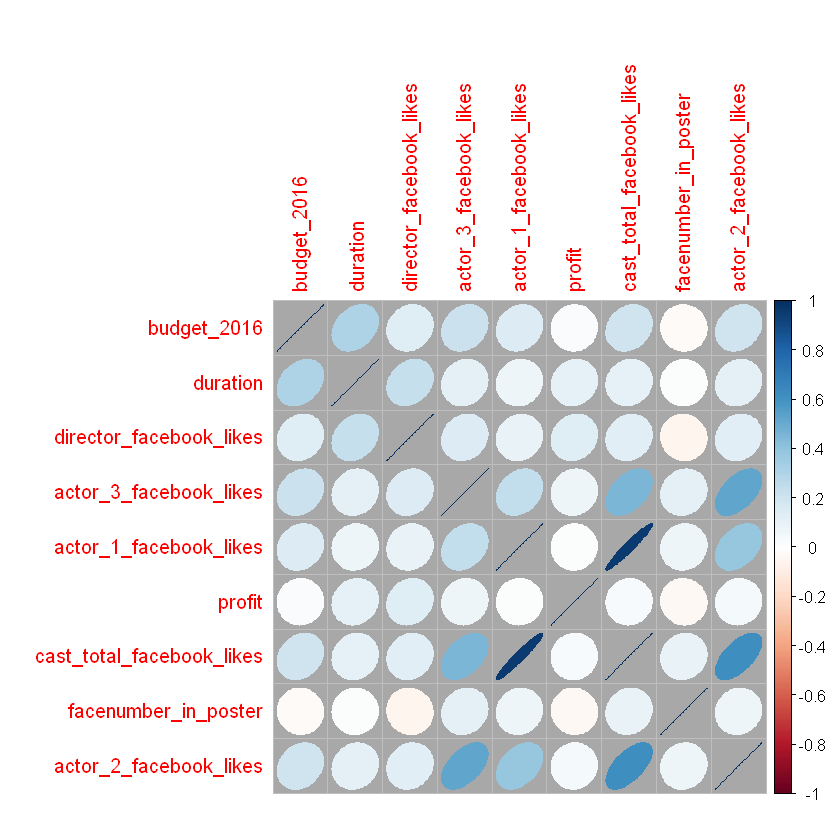

In [261]:
col_corr_plot<-c("budget_2016","duration","director_facebook_likes","actor_3_facebook_likes",
                                   "actor_1_facebook_likes","profit","cast_total_facebook_likes","facenumber_in_poster",
                                   "actor_2_facebook_likes")
corr_movie<-cor(movies[,col_corr_plot,with=FALSE], use = "na.or.complete")
#setkey(movies,NULL)
corrplot(corr_movie, method="ellipse", bg="#a8a8a8")

In [262]:
write.csv(movies,"movie_exploration.csv",row.names=FALSE, col.names=TRUE)

Warning message in write.csv(movies, "movie_exploration.csv", row.names = FALSE, :
"attempt to set 'col.names' ignored"